# OMAT (Optimal Mass Transfer) Metric

Based on equation (39) from:

Y. Li and M. J. Coates, "Particle Filtering with Invertible Particle Flow," IEEE Trans. Signal Process., vol. 65, no. 15, pp. 4102-4116, Aug. 2017.

$$d_p(X, \hat{X}) = \left(\frac{1}{C} \min_{\pi \in \Pi} \sum_{c=1}^C d(x_c, \hat{x}_{\pi(c)})^p\right)^{1/p}$$

The OMAT metric finds the optimal assignment between true and estimated targets that minimizes the total distance.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import permutations

## OMAT Metric Functions

In [ ]:
def compute_omat(true_states, estimated_states, n_target, p=1.0):
    """
    Compute OMAT metric using pure TensorFlow.

    Args:
        true_states: TensorFlow tensor, shape (state_dim,) or (state_dim, T)
        estimated_states: TensorFlow tensor, same shape
        n_target: Dimension of each target's state (e.g., 4 for [x, y, vx, vy])
        p: Exponent (default: 1.0)

    Returns:
        OMAT error (scalar tensor)
    """
    # Handle single time step
    if len(true_states.shape) == 1:
        true_states = tf.expand_dims(true_states, 1)
        estimated_states = tf.expand_dims(estimated_states, 1)

    # Calculate number of targets from state dimension
    state_dim = tf.shape(true_states)[0]
    num_targets = state_dim // n_target

    # Build cost matrix: cost[i,j] = distance from true target i to estimated target j
    cost_matrix = []
    for i in range(num_targets):
        row = []
        for j in range(num_targets):
            # Extract (x, y) positions
            true_pos = tf.stack([true_states[i*n_target, :], true_states[i*n_target+1, :]])
            est_pos = tf.stack([estimated_states[j*n_target, :], estimated_states[j*n_target+1, :]])

            # Euclidean distance
            diff = true_pos - est_pos
            dist = tf.sqrt(tf.reduce_sum(diff**2, axis=0))
            row.append(tf.reduce_mean(dist) ** p)
        cost_matrix.append(row)

    cost_matrix = tf.stack([tf.stack(row) for row in cost_matrix])

    # ============================================================
    # MINIMIZATION: Find optimal assignment
    # ============================================================
    # This implements: min_{π∈Π} Σ d(x_c, x̂_{π(c)})^p
    #
    # We try ALL permutations and find the one with MINIMUM total distance.
    #
    # Example: perm = (1, 0, 3, 2) means:
    #   True target 0 → Estimated target 1
    #   True target 1 → Estimated target 0
    #   True target 2 → Estimated target 3
    #   True target 3 → Estimated target 2
    # ============================================================

    min_cost = tf.constant(float('inf'), dtype=tf.float32)

    for perm in permutations(range(num_targets)):
        # Calculate total cost for this assignment
        cost = tf.reduce_sum([cost_matrix[i, perm[i]] for i in range(num_targets)])

        # *** MINIMIZATION HAPPENS HERE ***
        # Keep the smallest cost across all permutations
        min_cost = tf.minimum(min_cost, cost)

    # Apply OMAT formula: (min_cost / num_targets)^(1/p)
    return (min_cost / num_targets) ** (1.0 / p)


def compute_omat_per_timestep(true_states, estimated_states, n_target, p=1.0):
    """Compute OMAT at each time step using pure TensorFlow."""
    T = tf.shape(true_states)[1]
    errors = tf.TensorArray(dtype=tf.float32, size=T)

    for t in tf.range(T):
        error = compute_omat(true_states[:, t], estimated_states[:, t], n_target, p)
        errors = errors.write(t, error)

    return errors.stack()

In [ ]:
# Test with sample data
n_target = 4  # Each target has 4 state dimensions (e.g., x, y, vx, vy)
num_targets = 4  # Number of targets
T = 30

# Generate sample trajectories
# Total state dimension = n_target * num_targets = 16
true_states = tf.random.normal((n_target * num_targets, T))
estimated_states = true_states + tf.random.normal((n_target * num_targets, T)) * 0.5

# Compute OMAT errors
omat_errors = compute_omat_per_timestep(true_states, estimated_states, n_target)

print(f"Average OMAT error: {tf.reduce_mean(omat_errors):.4f}")
print(f"Final OMAT error: {omat_errors[-1]:.4f}")

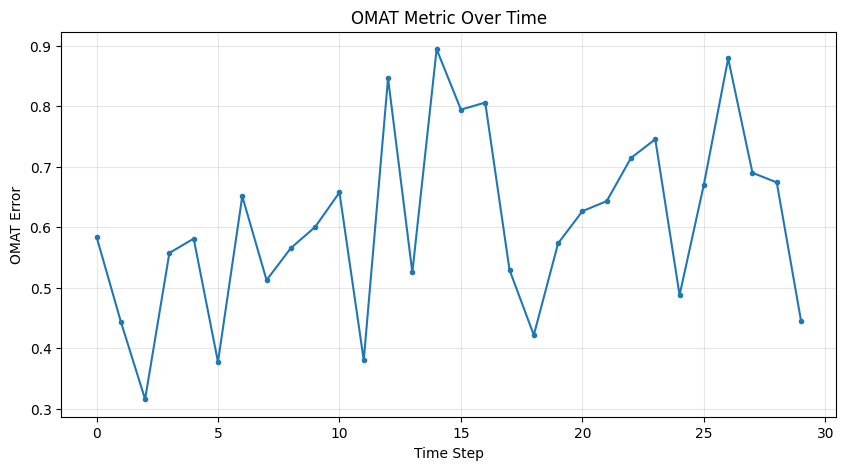

In [4]:
# Plot OMAT over time
plt.figure(figsize=(10, 5))
plt.plot(omat_errors.numpy(), marker='o', markersize=3)
plt.xlabel('Time Step')
plt.ylabel('OMAT Error')
plt.title('OMAT Metric Over Time')
plt.grid(True, alpha=0.3)
plt.show()